# Regressão Logística

In [15]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib
import urllib
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Exercício 1
*Objetivo: ler um dataset*

Neste roteiro, usaremos um dataset contendo informações usadas para detectar intenções de usuário interagindo com um chatbot. O [dataset](https://github.com/AmFamMLTeam/ACID) usado foi retirado do contexto de usuários interagindo com chatbots de uma seguradora de automóveis. Os dados fornecidos já estão divididos em conjuntos para treino e teste. A ideia dos dados é descobrir, através de uma frase digitada pelo usuário, qual é sua intenção:

In [16]:
TRAIN_URL = 'https://raw.githubusercontent.com/AmFamMLTeam/ACID/master/customer_training.csv'
TEST_URL = 'https://raw.githubusercontent.com/AmFamMLTeam/ACID/master/customer_testing.csv'
df_train = pd.read_csv(TRAIN_URL)
df_test = pd.read_csv(TEST_URL)
df_train.head()

,INTENT_NAME,UTTERANCES
0,INFO_ADD_HOUSE,add a homeowners policy
1,INFO_ADD_HOUSE,I just bought a house and want to add it to th...
2,INFO_ADD_HOUSE,How can I add my house to my existing policies
3,INFO_ADD_HOUSE,just purchased a house and need to add it to m...
4,INFO_ADD_HOUSE,I need to add a house to my policy


Podemos verificar que a quantidade de exemplos de frases para cada intenção é muito diferente.

1. Quantas intenções diferentes existem no dataset?
1. Quantos exemplos existem para a inteção com mais exemplos?
1. Quantos exemplos existem para a intenção com menos exemplos?

INFO_ADD_REMOVE_VEHICLE    189
INFO_LOGIN_ERROR           186
INFO_ERS                   180
INFO_ADD_REMOVE_INSURED    179
INFO_CAREERS               162
                          ... 
INFO_LIAB_EXPLAN             5
INFO_PYMT_TIME               5
INFO_RENTERS_COV_EXPLAN      5
INFO_UW_ALUMNI_DISCOUNT      5
INFO_PROFILE_SECTION         5
Name: INTENT_NAME, Length: 175, dtype: int64


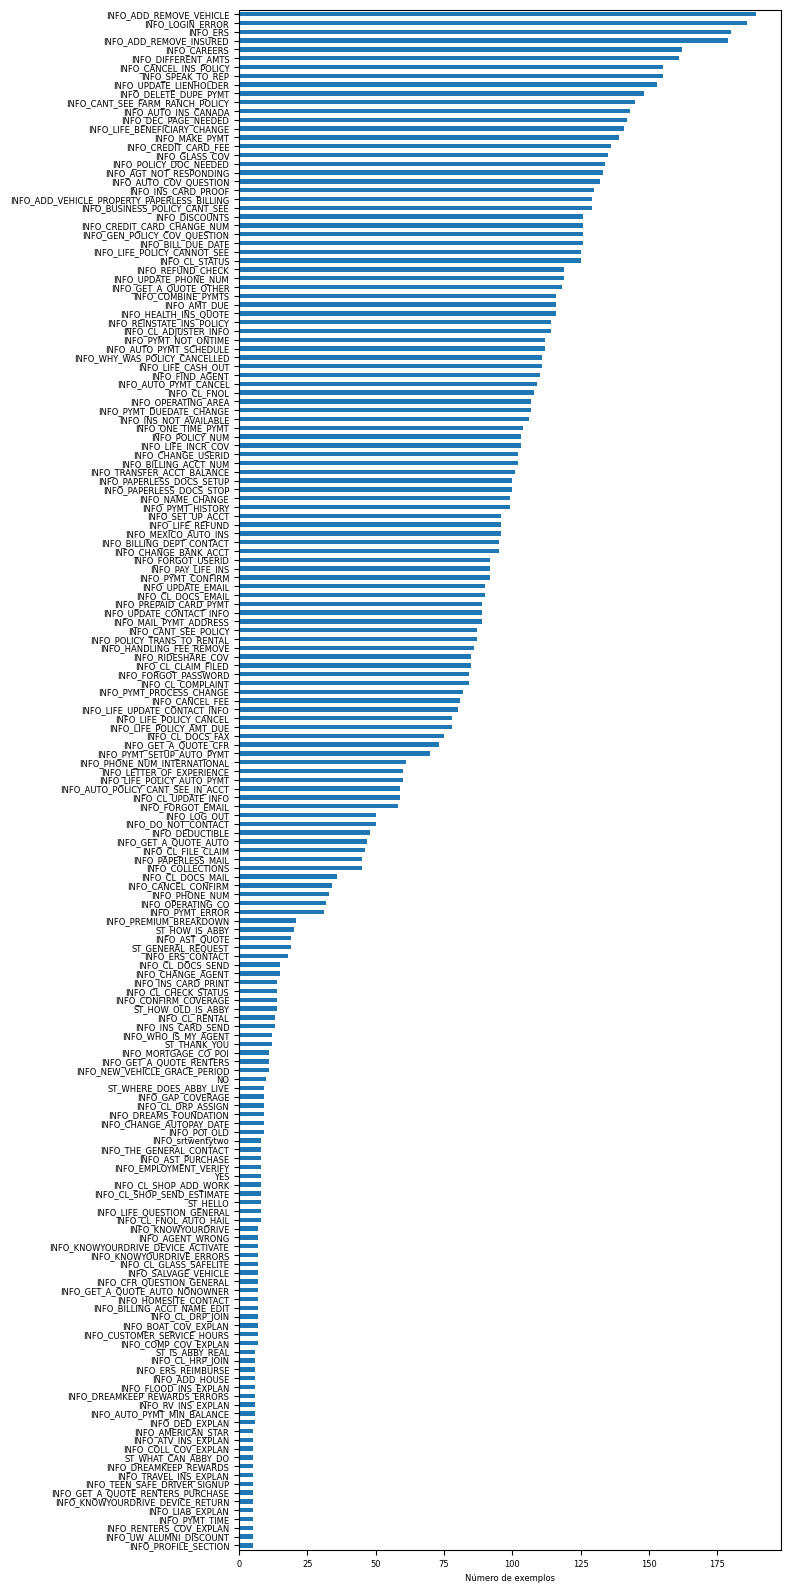

In [17]:
intent_count = df_train['INTENT_NAME'].value_counts()
print(intent_count)
plt.figure(figsize=(7,20))
plt.rcParams.update({'font.size': 6})
intent_count[::-1].plot.barh()
plt.xlabel('Número de exemplos')
plt.show()

## Exercício 2
*Objetivo: usar o regressor logístico para fazer a classificação das intenções*

O código abaixo permite separar somente $N$ intenções que têm mais exemplos e então realizar o processo de classificação.

Como o accuracy do sistema varia quando aumentamos o número de intenções que podem fazer parte de nosso vocabulário?


In [18]:
# Selecionar somente os N intents com mais dados
N_INTENTS = 5
allowed_intents = intent_count[0:N_INTENTS].index
filter_train = df_train['INTENT_NAME'].isin(allowed_intents) # filtro onde se quer true onde somente aparece as intencoes que estao autorizadas
df_train_ = df_train[filter_train]#pandas entende como uma selacao de linhas baseada em true e false
filter_test = df_test['INTENT_NAME'].isin(allowed_intents)
df_test_ = df_test[filter_test]
print(len(df_train), len(df_train_))

11130 896


In [19]:
X_train = df_train_['UTTERANCES']
y_train = df_train_['INTENT_NAME']

X_test = df_test_['UTTERANCES']
y_test = df_test_['INTENT_NAME']

classificador = Pipeline([
                        ('meu_vetorizador', CountVectorizer(stop_words='english')),
                        ('meu_classificador', LogisticRegression(penalty="l1", solver='saga', max_iter=10000))
                        ])
classificador.fit(X_train,y_train)
y_pred = classificador.predict(X_test)
acc = accuracy_score(y_pred,y_test)
print(acc)

0.9250559284116331


Penalty pode ser a norma L1, L2 ou nao existir...

L1 faz com que a quantidade de palavras diminua bastante, o que facilita a checagem manual.
L2 tende a ter um valor um pouco maior.

## Exercício 3
*Objetivo: determinar features mais relevantes na classificação logística*

No regressor logístico, para cada classe, há palavras que aumentam a probabilidade e palavras que diminuem a probabilidade, isto é, palavras com peso positivo e palavras com peso negativo. Leia o código e interprete os gráficos abaixo. Responda:

1. Quais palavras que, se estiverem presentes na frase digitada pelo usuário, são indícios fortes de que a intenção é `INFO_ADD_REMOVE_INSURED`?
1. Quais palavras que, se estiverem presentes na frase digitada pelo usuário, são indícios fortes de que a intenção **não é** `INFO_ADD_REMOVE_INSURED`?


(5, 693)


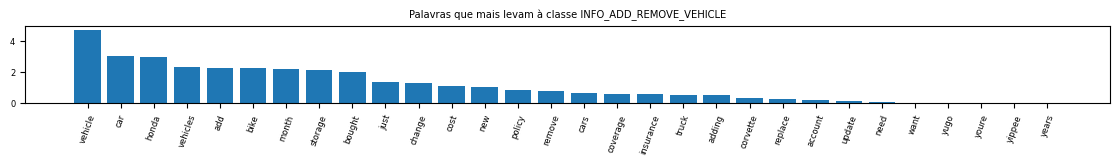

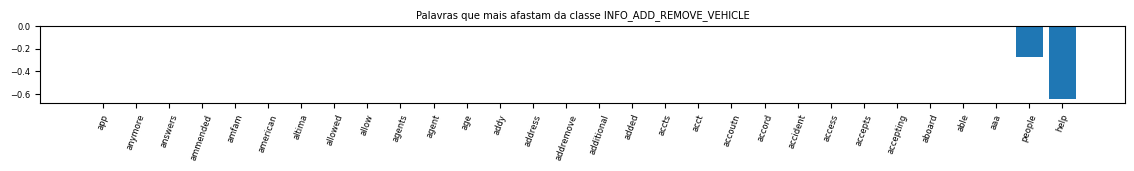

In [20]:
vocabulario = classificador['meu_vetorizador'].vocabulary_
pesos = classificador['meu_classificador'].coef_
print(pesos.shape)

classe_alvo = 1
classe_alvo_str = classificador.classes_[classe_alvo]

palavras_e_pesos = []
for palavra in vocabulario.keys():
    j = vocabulario[palavra]
    coeficiente = pesos[classe_alvo,j]
    palavras_e_pesos.append( (coeficiente, palavra) )

tuplas_ordenadas = sorted(palavras_e_pesos, reverse=True) # reverse=True pede uma ordenação em ordem decrescente
palavras = [ t[1] for t in tuplas_ordenadas ]
contagens = [ t[0] for t in tuplas_ordenadas ]

n_palavras = 30
eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais levam à classe ' + classe_alvo_str)
plt.bar(eixo_x[0:n_palavras], contagens[0:n_palavras])
plt.xticks(eixo_x[0:n_palavras], palavras[0:n_palavras], rotation=70)
plt.show()

eixo_x = np.arange(n_palavras)
plt.figure(figsize=(14,1))
plt.title('Palavras que mais afastam da classe ' + classe_alvo_str)
plt.bar(eixo_x[-n_palavras:], contagens[-n_palavras:])
plt.xticks(eixo_x[-n_palavras:], palavras[-n_palavras:], rotation=70)
plt.show()

## Exercício 4
*Objetivo: observar os efeitos das regularizações L2 e L1 nos coeficientes do regressor logístico*

Uma das possibilidades, em um regressor logísitico, é usar regularização nos pesos.

A regularização é uma penalidade adicionada ao erro (ou seja, é um valor minimizado junto com o erro) que muda algumas características dos pelos. As regularizações tipicamente implementadas são:

* `l2`: $l_2 = \sum_n ||a_n||^2$, isto é, a minimização da norma L2 busca diminuir a soma dos quadrados dos pesos, e
* `l1`: $l_1 = \sum_n ||a_n||$, isto é, a minimização da norma L1 busca diminuir a soma dos módulos dos pesos

Altere o código que define o processo de classificação trocando o parâmetro `penalty` de `None` para `'l2'`, e depois para `'l1'`. Verifique qual é o efeito da regularização no desempenho do classificador e nos pesos.

1. Que tipo de regularização leva a um sistema com maior desempenho? L2
1. Que tipo de regularização leva a um sistema mais fácil de interpretar? L1


# Exercício 5
*Objetivo: entender o problema da classificação open-set*

A avaliação dos sistemas que fizemos até o momento parte da ideia de que a frase que será escrita, quando o sistema estiver em produção, pertence com certeza a alguma das classes conhecidas. Porém, a realidade é que é possível que o usuário tente digitar uma frase que corresponda a uma intenção desconhecida. Então, a avaliação, neste caso, não deve ser realizada pensando num conjunto fechado (closed set) de intenções, e sim num conjunto aberto (open set), do qual conhecemos apenas algumas das intenções.

Uma maneira de lidar com essa situação é usar o método `predict_log_proba`, que retorna ao log da probabilidade de cada predição:

In [21]:
print(classificador.classes_)
print(classificador.predict_log_proba( X_test.iloc[0:2]))
print(classificador.predict( X_test.iloc[0:2]))

['INFO_ADD_REMOVE_INSURED' 'INFO_ADD_REMOVE_VEHICLE' 'INFO_CAREERS'
 'INFO_ERS' 'INFO_LOGIN_ERROR']
[[-4.36305819e-04 -7.98061706e+00 -1.15309418e+01 -9.73329218e+00
  -1.05932774e+01]
 [-5.49899319e-03 -5.63123108e+00 -7.96934251e+00 -6.81991493e+00
  -7.67990014e+00]]
['INFO_ADD_REMOVE_INSURED' 'INFO_ADD_REMOVE_INSURED']


Veja que a classe que o classificador retorna é simplesmente aquela cujo log_proba é máximo - neste caso, a classe 0 (INFO_ADD_REMOVE_INSURED). Se usarmos uma entrada que não representa nenhuma intenção do dataset, temos um outro cenário:

In [22]:
frase = 'I would like to order a big mac and fries, please'
print(classificador.predict_log_proba([frase]))
print(classificador.predict([frase]))

[[-2.0599636  -2.37083287 -0.67385575 -1.78056762 -2.29405477]]
['INFO_CAREERS']


Veja que, neste caso, todas as probabilidades relacionadas a classes são relativamente baixas. Mesmo assim, alguma delas foi escolhida como "a mais alta" e o sistema interpretou nosso pedido de big mac com fritas como uma das possíveis intenções presentes no conjunto de treinamento. O procedimento correto, porém, é de encontrar um limiar que permita dizer que a máxima probabilidade predita ainda é muito baixa.

Para encontrar esse limiar podemos ter várias "regras". Uma delas é usar um percentil das probabilidades preditas no conjunto de treino:

In [23]:
log_probas = classificador.predict_log_proba(X_train)
m = np.max(log_probas, axis=1)
th = np.percentile(m, 5) #pegando o percentil 5, para reduzir a chance de ter pego algo que vc nao sabe dizer o que é
print(th)

-0.6010156360017962


Então, para cada predição, se o log_proba correspondente for menor que o limiar `th`, dizemos que a entrada pertence a um conjunto desconhecido:

In [24]:
frase = "hey, jude, don't take it bad, take a sad song and make it better"
intent = classificador.predict([frase])
prob = classificador.predict_log_proba([frase]).max()
if prob < th:
    intent = 'UNKNOWN'

print(intent)

UNKNOWN


Usando essa técnica, determine, para o conjunto de teste:

1. Qual é a probabilidade de uma frase com uma intenção conhecida ser erroneamente classificada como "UNKNOWN"?
1. Qual é a probabilidade de uma frase com uma intenção desconhecida ser erroneamente classificada como de uma intenção conhecida?

In [25]:
probas = classificador.predict_log_proba(X_test)# no X_test se sabe todas as intencoes
m = np.max(probas, axis=1)
eu_sei = m <th
print(np.sum(eu_sei)/len(m))# eu nao sei quando eu sabia

0.08501118568232663


In [26]:
# Selecionar somente os N intents com mais dados
N_INTENTS = 5
disallowed_intents = intent_count[N_INTENTS:].index
filter_test_open = df_test['INTENT_NAME'].isin(disallowed_intents)
df_test_open = df_test[filter_test_open]

X_test_open = df_test_open['UTTERANCES']
probas = classificador.predict_log_proba(X_test_open)
m = np.max(probas, axis=1)
eu_nao_sei = m > th
print(np.sum(eu_nao_sei)/len(m))

0.3377020102483248


resposta certa é que eu nao sei. visto que nao foram usados no treino

vai te dizer que sabe, sem saber: